# Coche autónomo mediante Deep Learning

Autor: Andrés Martínez Martínez

##Imports

In [38]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
# common use
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random

# image transformation
from imgaug import augmenters as iaa
from PIL import Image

# machine learning
import tensorflow as tf
import keras
import cv2
from sklearn.model_selection import train_test_split

print( f'tf.version: {tf.__version__}')
print( f'keras.version: {keras.__version__}')

tf.version: 2.8.2
keras.version: 2.8.0


##Load dataset

###Import data

In [40]:
# import images and get a list with its paths
data_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/data/manual-images'
file_list = [] #os.listdir(data_dir)
for root, dir, files in os.walk(data_dir):
  for name in files:
    file_list.append(os.path.join(root,name))
#print(file_list)
image_paths = [i for i in file_list if i[-4:] == '.png'] # we only want files with .png extension
#image_paths = [data_dir + '/' + name for name in image_list]

# get list of angles from file names, 90 degrees is follow straight
steering_angles = [int(name[-7:-4]) for name in image_list]

print('number of images: %d' % len(image_paths))
print('number of angles: %d' % len(steering_angles))

number of images: 1841
number of angles: 1841


### Show sample

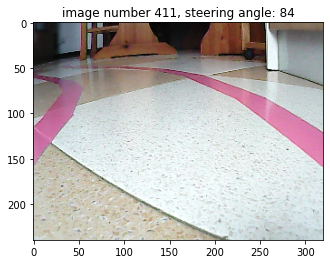

In [41]:
# show an image and its angle
index = np.random.randint(0, len(image_paths) - 1)
plt.imshow(Image.open(image_paths[index]))
plt.title('image number %d, steering angle: %d' % (index, steering_angles[index]))
plt.show()

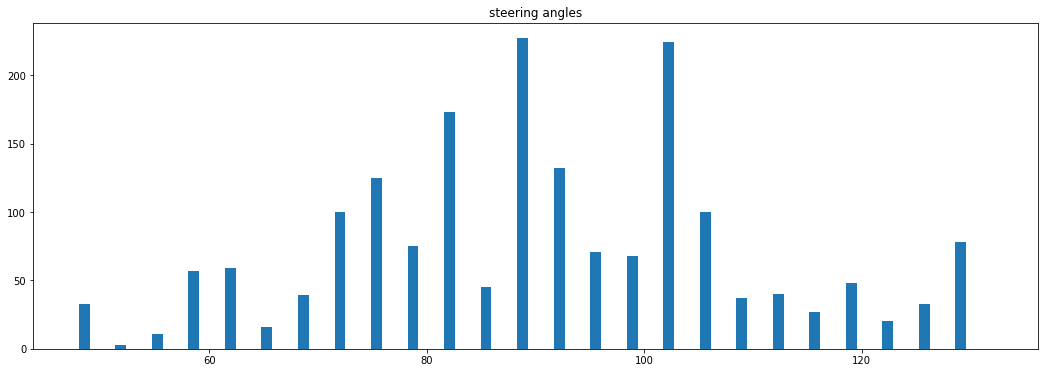

In [42]:
# check distribution of steering angles
fig, axes = plt.subplots(figsize=(18,6))
plt.hist(steering_angles, bins=25, width=1)
plt.title('steering angles')
plt.show()

## Augment dataset

In [81]:
def im_augment(im, st_angle):
  # im must be cv2 image

  # flip
  if np.random.rand() < 0:
    im = cv2.flip(im,1)
    st_angle = 180 - st_angle
  
  # blur
  if np.random.rand() < 0.5:
    ksize = np.random.randint(1,5)
    im = cv2.blur(im, (ksize, ksize))

  # bright
  if np.random.rand() < 0.5:
    brightness = iaa.Multiply((0.5, 1.5))
    im = brightness.augment_image(im)

  return im, st_angle

### Show sample

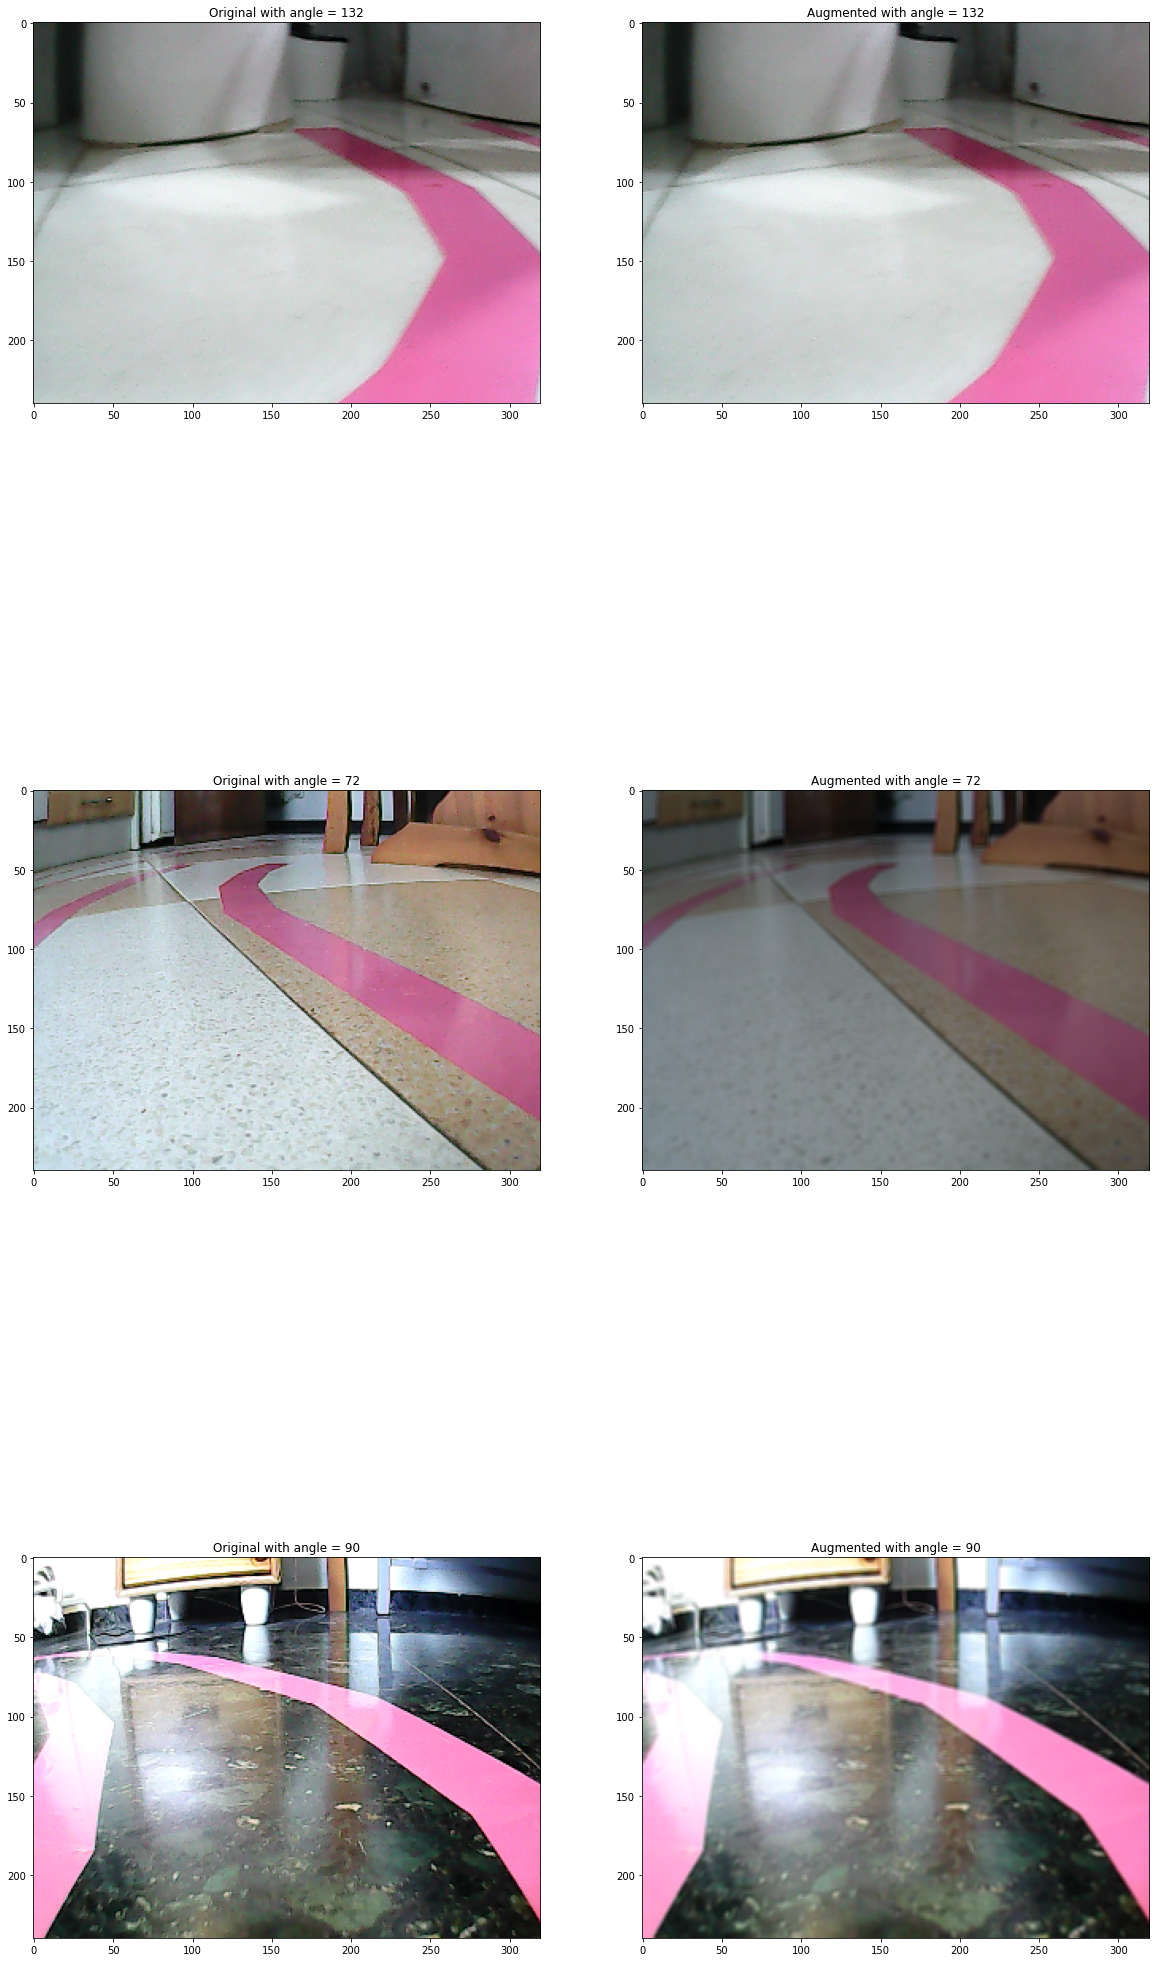

In [82]:
nimages = 3
fig, axes = plt.subplots(nimages, 2, figsize=(20,40))

for i in range(nimages):
  index = np.random.randint(0, len(image_paths) - 1)

  im = cv2.imread(image_paths[index])
  im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
  st_angle = steering_angles[index]

  im_aug, st_angle_aug = im_augment(im, st_angle)

  axes[i][0].imshow(im)
  axes[i][0].set_title("Original with angle = %d" % st_angle)
  axes[i][1].imshow(im_aug)
  axes[i][1].set_title("Augmented with angle = %d" % st_angle_aug)

## Preprocess dataset

In [96]:
def im_preprocess(cv2_image):

  im = cv2_image[int(len(cv2_image)/2):,:,:] # cut top 1/2 of image
  im = cv2.resize(im, (200,66))
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = np.array(im)
  im = im / 255

  return im

### Show sample

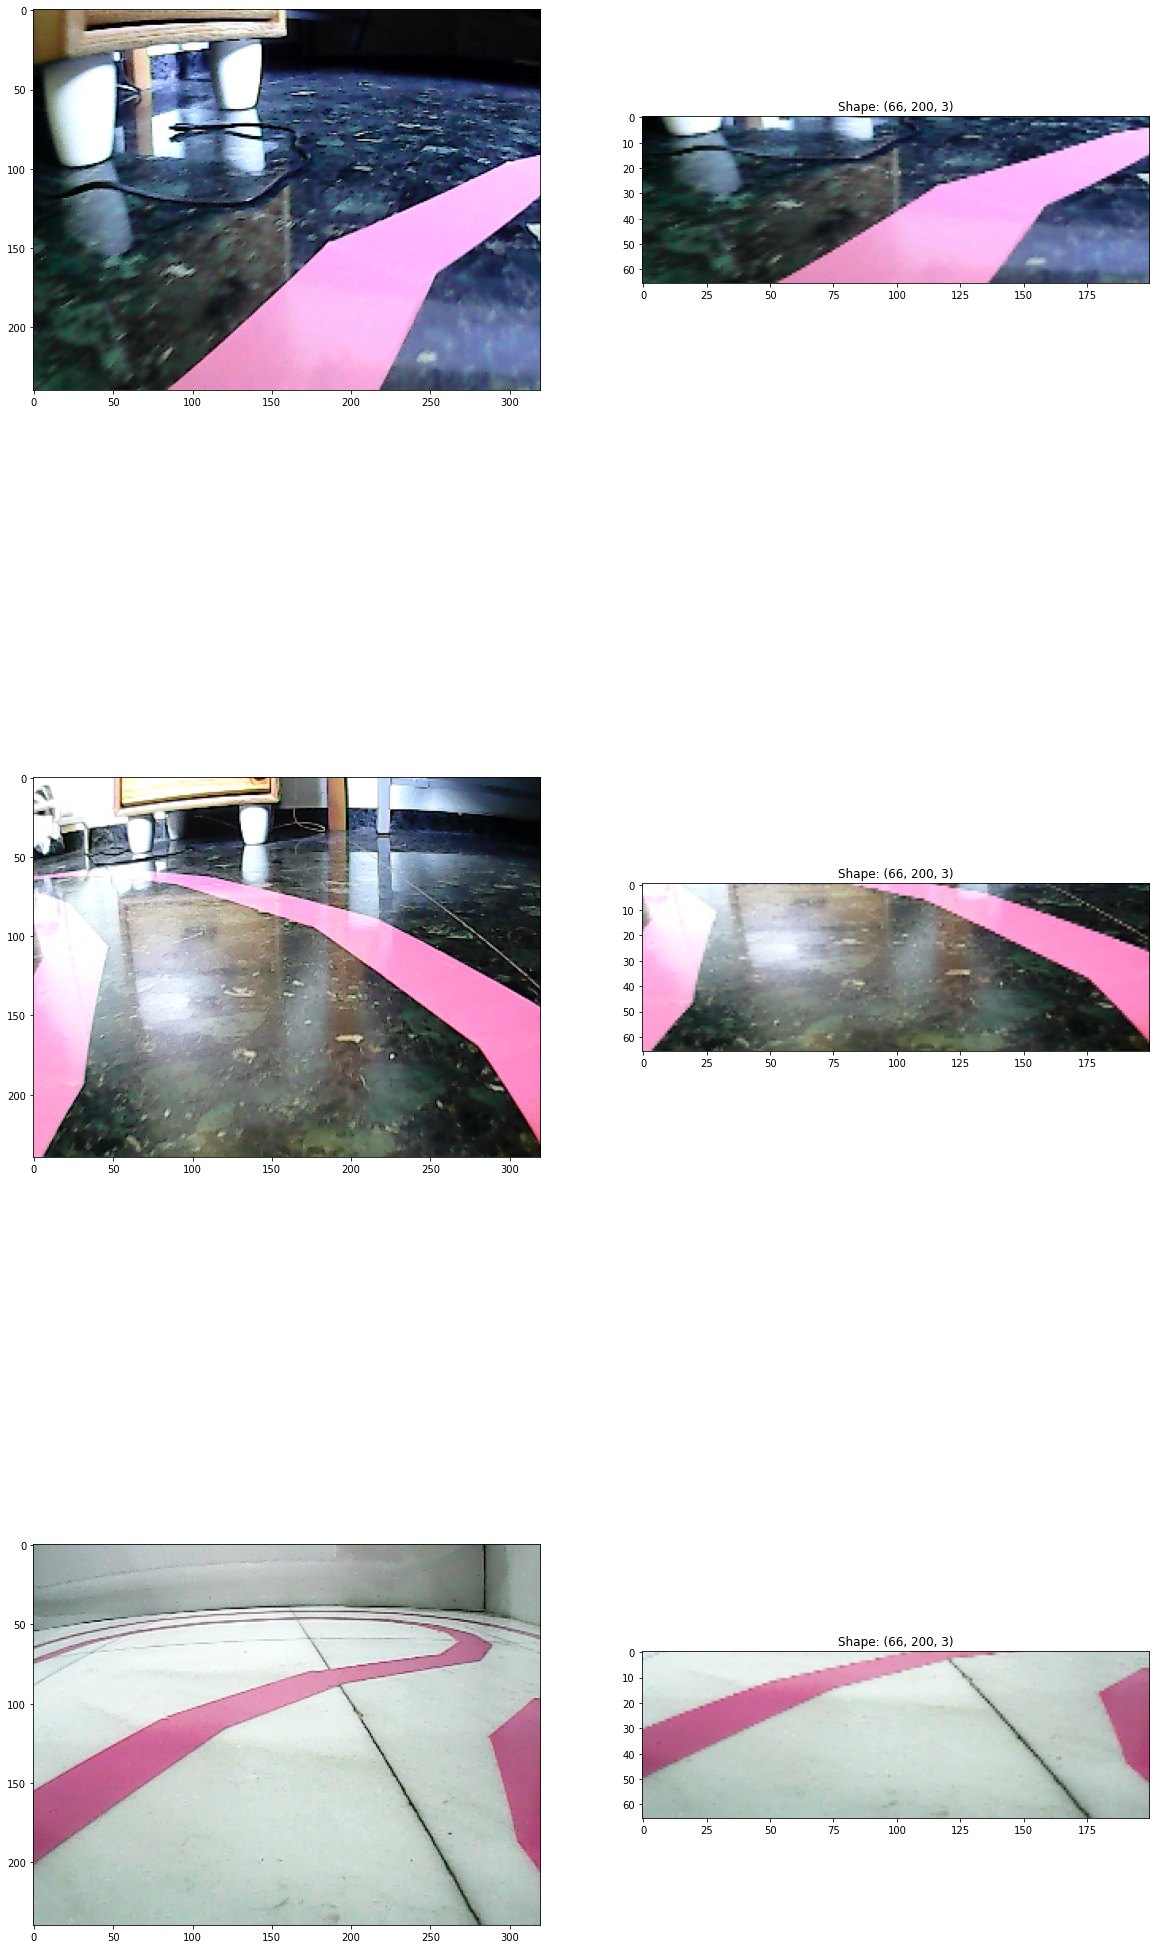

In [83]:
nimages = 3
fig, axes = plt.subplots(nimages, 2, figsize=(20,40))

for i in range(nimages):
  index = np.random.randint(0, len(image_paths) - 1)

  im = cv2.imread(image_paths[index])

  im_ready = im_preprocess(im)

  axes[i][0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
  axes[i][1].imshow(im_ready)
  axes[i][1].set_title(f"Shape: {im_ready.shape}")

## Prepare datasets: training & validation

### Split into training and validation sets

Number of training examples: 1472
Number of validation examples: 369


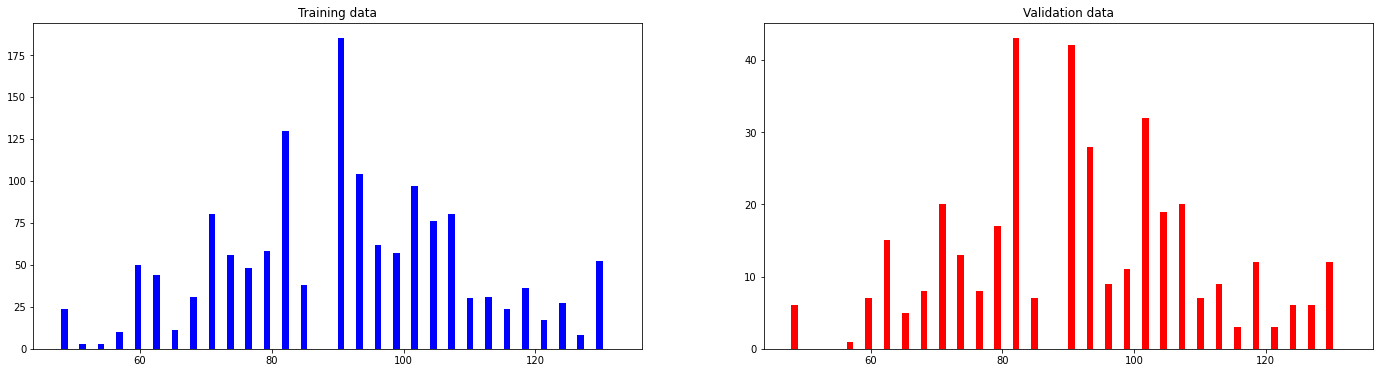

In [47]:
# split into training and validation sets
paths_train, paths_val, angles_train, angles_val = train_test_split(image_paths, steering_angles, test_size=0.2, random_state=123)
print("Number of training examples: %d\nNumber of validation examples: %d" % (len(paths_train), len(paths_val)))

# check distribution of both sets
fig, axes = plt.subplots(1,2, figsize=(24, 6))
axes[0].hist(angles_train, bins=30, width=1, color='blue')
axes[0].set_title('Training data')
axes[1].hist(angles_val, bins=30, width=1, color='red')
axes[1].set_title('Validation data')
plt.show()

### Validation dataset

In [48]:
# create numpy arrays for validation dataset
X_val = np.array([im_preprocess(cv2.imread(i)) for i in paths_val])
Y_val = np.array(angles_val)

### Training dataset: batch generator

In [84]:
class data_generator(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.Random(123).shuffle(self.x)
            np.random.Random(123).shuffle(self.y)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        '''return np.array([im_preprocess(im_augment(cv2.imread(i))) for i in batch_x]), np.array(batch_y)'''

        images = []

        for i in range(len(batch_x)):
          im = cv2.imread(batch_x[i])

          im, batch_y[i] = im_augment(im, batch_y[i])
          im = im_preprocess(im)
          
          images.append(im)
        
        return np.array(images), np.array(batch_y)

In [104]:
def old_generator(image_paths, steering_angles, batch_size):

  batch_images = []
  batch_steering_angles = []
  seed = 123

  for i in range(batch_size):
    index = random.Random(i+seed).randint(0, len(image_paths) - 1)
    im = cv2.imread(image_paths[index])
    
    im, st_angle = im_augment(im, steering_angles[index])

    im = im_preprocess(im)

    batch_images.append(im)
    batch_steering_angles.append(st_angle)

  yield np.asarray(batch_images), np.asarray(batch_steering_angles)

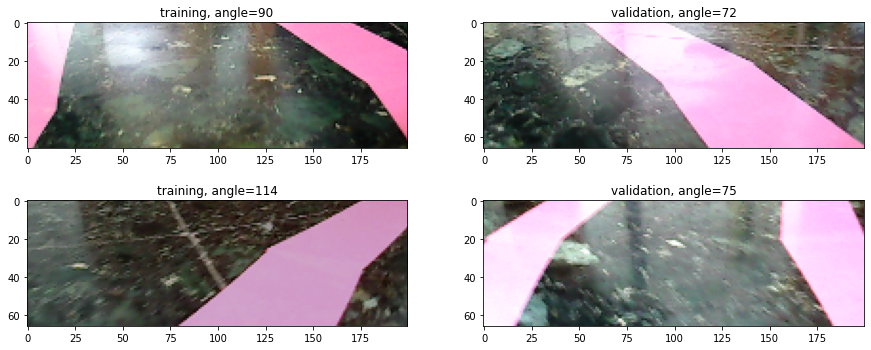

In [105]:
#test

nrows = 2
ncols = 2

X_train_batch, y_train_batch = next(old_generator(paths_train, angles_train, nrows))
X_valid_batch, y_valid_batch = next(old_generator(paths_val, angles_val, nrows))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))
#fig.tight_layout()

for i in range(nrows):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

## Deep learning model

### Without resizing

In [51]:
# original size
'''#from keras.backend import relu
def model_nvidia():

  model = keras.Sequential(name='Model_Nvidia')

  # conv layers

  model.add(keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(80, 160, 3), activation='elu')) # 38x78 output
  model.add(keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu')) # 17x37 output
  model.add(keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu')) # 7x17 output

  model.add(keras.layers.Conv2D(64, 5, activation='elu')) # 3x13 output
  model.add(keras.layers.Conv2D(64, 3, activation='elu')) # 1x11 output

  # fully connected layers
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(100, activation='elu'))
  model.add(keras.layers.Dense(50, activation='elu'))
  model.add(keras.layers.Dense(10, activation='elu'))

  # output layer
  model.add(keras.layers.Dense(1))

  # loss
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mse', optimizer=opt)

  return model'''

"#from keras.backend import relu\ndef model_nvidia():\n\n  model = keras.Sequential(name='Model_Nvidia')\n\n  # conv layers\n\n  model.add(keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(80, 160, 3), activation='elu')) # 38x78 output\n  model.add(keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu')) # 17x37 output\n  model.add(keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu')) # 7x17 output\n\n  model.add(keras.layers.Conv2D(64, 5, activation='elu')) # 3x13 output\n  model.add(keras.layers.Conv2D(64, 3, activation='elu')) # 1x11 output\n\n  # fully connected layers\n  model.add(keras.layers.Flatten())\n\n  model.add(keras.layers.Dense(100, activation='elu'))\n  model.add(keras.layers.Dense(50, activation='elu'))\n  model.add(keras.layers.Dense(10, activation='elu'))\n\n  # output layer\n  model.add(keras.layers.Dense(1))\n\n  # loss\n  opt = tf.keras.optimizers.Adam(learning_rate=0.001)\n  model.compile(loss='mse', optimizer=opt)\n\n  return model"

### With resizing

In [99]:
model = keras.Sequential([
  # conv layers
  keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(66, 200, 3), activation='elu'),
  keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu'),
  keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu'),
  keras.layers.Conv2D(64, 3, activation='elu'),
  keras.layers.Conv2D(64, 3, activation='elu'),

  # fully connected layers
  keras.layers.Flatten(),

  keras.layers.Dense(100, activation='elu'),
  keras.layers.Dense(50, activation='elu'),
  keras.layers.Dense(10, activation='elu'),

  # output layer
  keras.layers.Dense(1)
])

### Model summary

In [100]:
# loss
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=opt)

In [101]:
model.build((66,200,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_8 (Dense)             (None, 100)              

## Model training

In [ ]:
# history = None

In [106]:
model_output_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_follower_checkpoint.h5'), verbose=1, save_best_only=True)

history = model.fit(old_generator(paths_train, angles_train, 32),
                    epochs=20,
                    steps_per_epoch=10,
                    validation_data = (X_val, Y_val),
                    verbose=1,
                    callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir,'lane_follower.h5'))

Epoch 1/20
 1/10 [==>...........................] - ETA: 1s - loss: 8606.1162WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 200 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 7906.27490, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/lane_follower_checkpoint.h5
10/10 [==============================] - 1s 114ms/step - loss: 8606.1162 - val_loss: 7906.2749


## Review performance

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.title('RGB, ELU, Dropout')
plt.xlabel('epoch',labelpad=2)
ax.yaxis.tick_right()
plt.show()

## TF Lite conversion

In [ ]:
os.chdir(model_output_dir)
best_model = tf.keras.models.load_model('best model/autonomous_car_final.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

with open('autonomous_car_model.tflite', 'wb') as f:
  f.write(tflite_model)